*Ссылка на репозиторий GitHub:* https://github.com/noncfg/yandex_praktikum_git_project

# Проект: Обучение с учителем: качество модели

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 


Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных**

**market_file.csv**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_money.csv**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

**market_time.csv**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

**money.csv**

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

In [1]:
!pip install scikit-learn==1.1.3
!pip install shap -q
!pip -q install phik

     |████████████████████████████████| 30.8 MB 1.2 MB/s eta 0:00:01███ | 29.9 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import numpy as np
from scipy import stats as st
from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV, 
                                     GridSearchCV
                                    )
import phik
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder, 
                                   StandardScaler,
                                   MinMaxScaler, 
                                   LabelEncoder
                                  )
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import shap
import pickle

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 11,7

## Шаг. Загрузка данных

### Загрузите данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv доступны по ссылкам в описании данных или через пути к ним:

- /datasets/market_file.csv
- /datasets/market_money.csv
- /datasets/market_time.csv
- /datasets/money.csv


Обратите внимание: в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая. 

In [5]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

Все три датасета загрузились без проблем из файлов. 

Разделителем строк оказалась запятая, но в файле **money.csv** это была точка с запятой. 

### Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [6]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Столбцы совпадают с описанием.

Пропуски в данных не наблюдаем. 

Названия некоторых столбцов содержат пробелы, нужно будет исправить в дальнейшем. 

Тип данных некоторых столбцов, например, Маркет_актив_6_мес и Акционные_покупки не совпадает с описанием.


In [9]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [11]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Столбцы совпадают с описанием. 

Пропуски в данных не наблюдаем. 

Тип данных столбца Выручка не совпадает с описанием. 

Кроме того, есть записи с выручкой 0 и с выручкой более 100 000, выглядят странно, проверим это в дальнейшем.


In [12]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [13]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Столбцы совпадают с описанием.

Пропуски в данных не наблюдаем. 


In [15]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [16]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [17]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Столбцы совпадают с описанием. 

Пропуски в данных не наблюдаем. 


**Вывод:**

Данные в таблицах соответствуют описанию.

## Шаг. Предобработка данных

### Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

**Переименование столбцов**

Так как в рамках проекта позволено оставить кириллические наименование столбцов, то просто заменим пробелы на подчеркивания.


In [18]:
def columns_remove_spaces(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [19]:
columns_remove_spaces(market_file)

In [20]:
columns_remove_spaces(market_money)

In [21]:
columns_remove_spaces(market_time)

In [22]:
columns_remove_spaces(money)

In [23]:
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

**Проверка на дубликаты**

In [24]:
for i in [market_file, market_money, market_time, money]:
    display(i.duplicated().sum())

0

0

0

0

In [25]:
cols_mf = market_file.select_dtypes(include='object').columns.tolist()
cols_mf

['покупательская_активность',
 'тип_сервиса',
 'разрешить_сообщать',
 'популярная_категория']

In [26]:
for col in cols_mf:
    display(market_file[col].value_counts())

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

In [27]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('тт', 'т', regex=True)
market_file['популярная_категория'] = market_file['популярная_категория'].replace('аксесуары', 'аксессуары', regex=True)

In [28]:
cols_mm = market_money.select_dtypes(include='object').columns.tolist()
cols_mm

['период']

In [29]:
for col in cols_mm:
    display(market_money[col].value_counts())

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64

In [30]:
cols_mt = market_time.select_dtypes(include='object').columns.tolist()
cols_mt

['период']

In [31]:
for col in cols_mt:
    display(market_time[col].value_counts())

предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

In [32]:
market_time['период'] = market_time['период'].replace('дц', 'ду', regex=True)

**Вывод:**

Пропусков и явных дубликатов в данных нет. 

Исправлены опечатки

## Шаг. Исследовательский анализ данных

### Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

In [33]:
# Группировка значений
def quality_go_groupby(data, column):
    if 'subscription_fee' in market_file.columns:
        result = subscriptions_go_translate(data).groupby([column])[column].agg(['count']).sort_values(by='count')
    else:
        result = data.groupby([column])[column].agg(['count']).sort_values(by='count')
    result['percent'] = result['count'] / result['count'].sum()
    return result

In [34]:
# Визуализации столбцов с качественными данными
def quality_go(data, column, xlabel, ylabel, title):
    print('Название столбца:', column)
    go = quality_go_groupby(data, column)
    go.columns = {'Количество':'count', 'Доля':'percent'}
    
 
    ax = sns.countplot(data = data, x = column, color='steelblue');
    for i in ax.patches:
        height = i.get_height()
        ax.text(i.get_x() + i.get_width()/2.,
                height + 3,
                '{:1}'.format(height),
                horizontalalignment='center', verticalalignment='bottom')

    plt.title(f'{title}', fontsize = 15);
    plt.xlabel(f'{xlabel}', fontsize = 15);
    plt.ylabel(f'{ylabel}', fontsize = 15);
    plt.show()
    
    print('Значения датафрейма:')
    print(go)
    print('\nОписание датафрейма:')
    print(go['Количество'].describe())

In [35]:
# Функция визуализации столбцов с количественными данными
def quantity_go(data, column, bins_num, xlabel, ylabel, title):
    print('Название столбца:', column)
    ax = data[column].hist(bins=bins_num)
    
    plt.title(f'{title}', fontsize = 15);
    plt.xlabel(f'{xlabel}', fontsize = 15);
    plt.ylabel(f'{ylabel}', fontsize = 15);
    plt.show()
    
    print('Описание датафрейма:')
    print(data[column].describe().round(0))

In [36]:
def pivot_bar_plot(data, column):
    plt.figure(figsize=(15,7))
    ax = sns.barplot(x=column, data=data, y=data.index, color='steelblue')
    
    
    plt.title(f'Рапределение по {column}', fontsize=15)
    plt.xlabel('Количество', fontsize=15)
    plt.show()
    
    print('Описание датафрейма:')
    print(data[column].describe().round(0))

In [37]:
def hist_with_wiskers(data, column, target):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(17, 7))
    axes[0].set_title(f'Гистограмма для {column}', fontsize=15)
    axes[0].set_ylabel('Количество', fontsize=15)
    if target != None:
        sns.histplot(data, bins=20, kde=True, ax=axes[0], hue=target, x=column)
    else:
        sns.histplot(data, bins=20, kde=True, ax=axes[0], x=column)
    axes[1].set_title(f'График ящик с усами для {column}', fontsize=15)
    sns.boxplot(data=data, ax=axes[1], y=column)
    axes[1].set_ylabel(column, fontsize=15)
    plt.show()

In [38]:
def histogram(data, column, target):
   # plt.figure(figsize=(8,6))
    plot = sns.histplot(data, bins=20, kde=True, hue=target, x=column)
    plot.set_title(f'Рапределение по {column}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)

In [39]:
# Визуализации столбцов с качественными данными
def quality_go(data, column, xlabel, ylabel, title):
    print('Название столбца:', column)
    go = quality_go_groupby(data, column)
    go.columns = {'Количество':'count', 'Доля':'percent'}
    
 
    ax = sns.countplot(data = data, y = column, color='steelblue');
    for idx, p in enumerate(ax.patches):
        freq = 0 if np.isnan(p.get_width()) else int(p.get_width())
        ax.annotate("{}".format(freq), 
                (freq + 5, p.get_y() + 0.425), 
                )

    plt.title(f'{title}', fontsize = 15);
    plt.xlabel(f'{xlabel}', fontsize = 15);
    plt.ylabel(f'{ylabel}', fontsize = 15);
    plt.show()
    
    print('Значения датафрейма:')
    print(go)
    print('\nОписание датафрейма:')
    print(go['Количество'].describe())

Название столбца: покупательская_активность


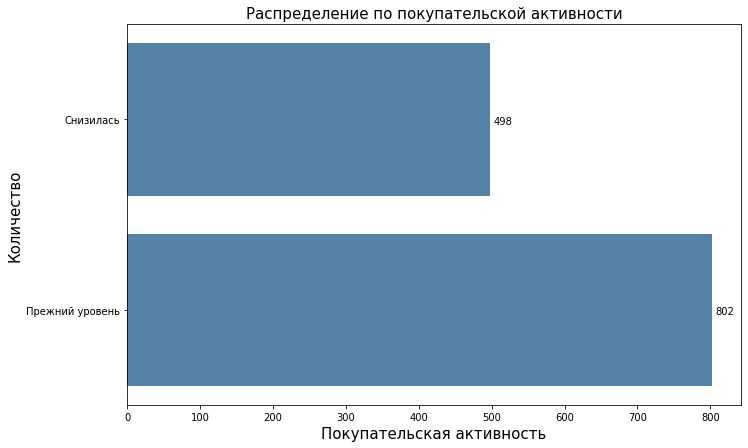

Значения датафрейма:
                           Количество      Доля
покупательская_активность                      
Снизилась                         498  0.383077
Прежний уровень                   802  0.616923

Описание датафрейма:
count      2.000000
mean     650.000000
std      214.960461
min      498.000000
25%      574.000000
50%      650.000000
75%      726.000000
max      802.000000
Name: Количество, dtype: float64


In [40]:
quality_go(
    market_file, 
    'покупательская_активность',
    'Покупательская активность',
    'Количество', 
    'Распределение по покупательской активности'
)

Видим некоторый дисбаланс значений в целевом признаке, это нужно будет учесть в модели.

Название столбца: тип_сервиса


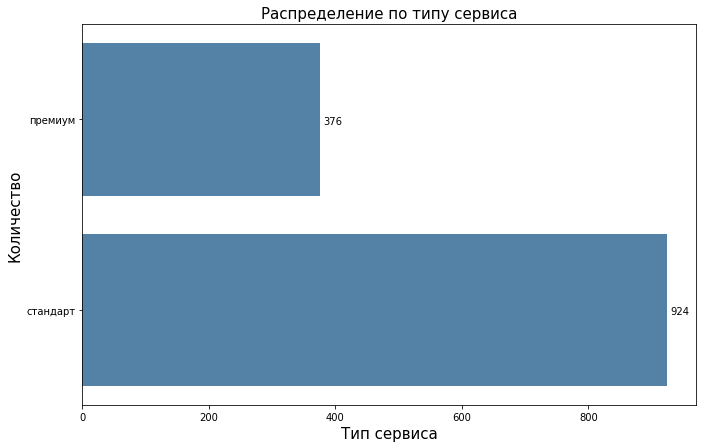

Значения датафрейма:
             Количество      Доля
тип_сервиса                      
премиум             376  0.289231
стандарт            924  0.710769

Описание датафрейма:
count      2.000000
mean     650.000000
std      387.494516
min      376.000000
25%      513.000000
50%      650.000000
75%      787.000000
max      924.000000
Name: Количество, dtype: float64


In [41]:
quality_go(
    market_file, 
    'тип_сервиса',
    'Тип сервиса',
    'Количество', 
    'Распределение по типу сервиса'
)

Обратим внимание, что премиум пользователей меньше, что и логично.

Название столбца: разрешить_сообщать


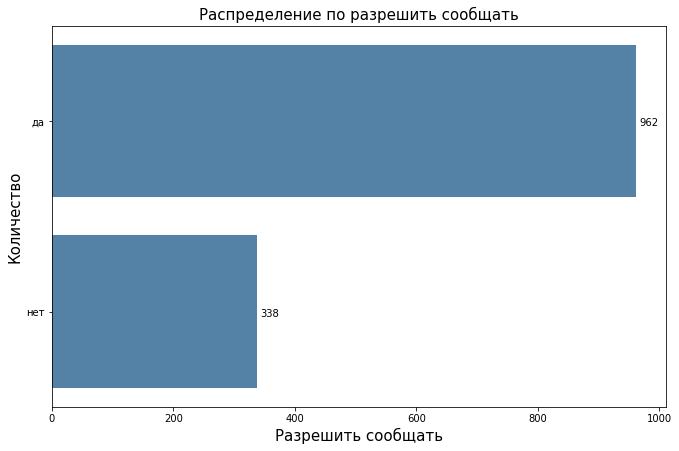

Значения датафрейма:
                    Количество  Доля
разрешить_сообщать                  
нет                        338  0.26
да                         962  0.74

Описание датафрейма:
count      2.000000
mean     650.000000
std      441.234631
min      338.000000
25%      494.000000
50%      650.000000
75%      806.000000
max      962.000000
Name: Количество, dtype: float64


In [42]:
quality_go(
    market_file, 
    'разрешить_сообщать',
    'Разрешить сообщать',
    'Количество', 
    'Распределение по разрешить сообщать'
)

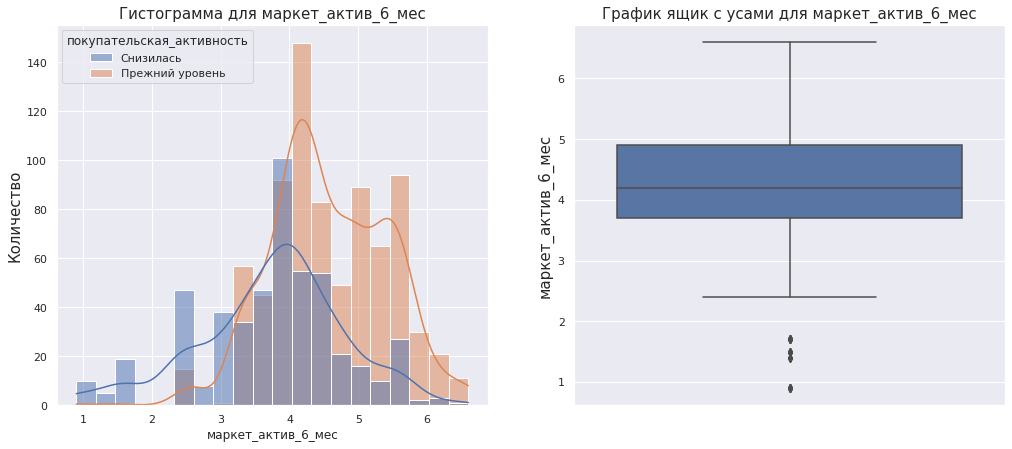

In [43]:
hist_with_wiskers(market_file, 'маркет_актив_6_мес', 'покупательская_активность')

In [44]:
market_file.query('маркет_актив_6_мес < 2')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
30,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,Снизилась,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,Снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
55,215403,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
61,215409,Снизилась,премиум,да,1.4,4,857,0.95,Кухонная посуда,3,4,5,5
63,215411,Снизилась,стандарт,да,1.7,4,756,0.33,Товары для детей,2,3,7,4
70,215418,Снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
81,215429,Снизилась,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4
108,215456,Снизилась,стандарт,да,1.7,4,449,0.23,Косметика и аксессуары,3,4,4,5


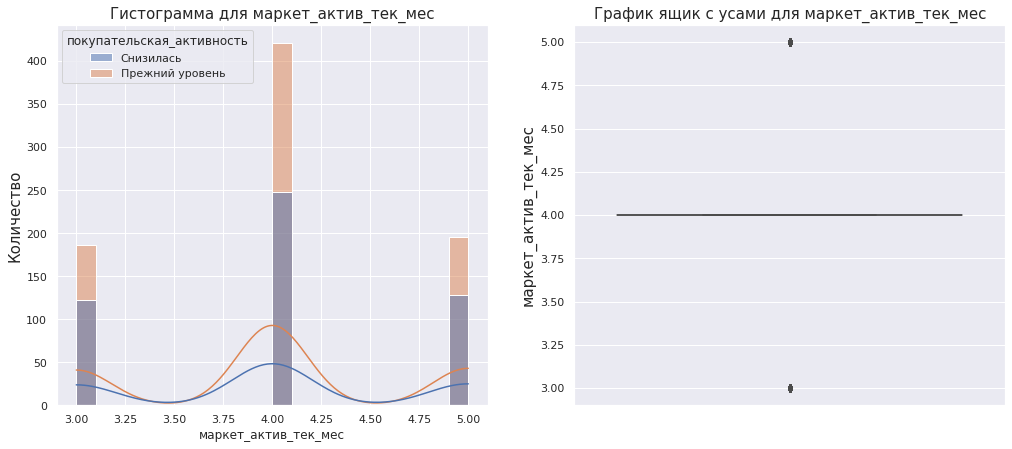

In [45]:
hist_with_wiskers(market_file, 'маркет_актив_тек_мес', 'покупательская_активность')

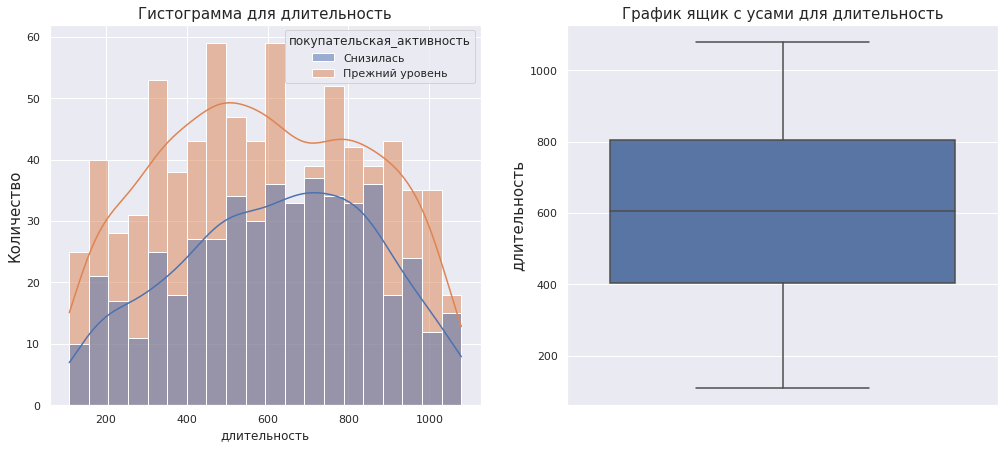

In [46]:
hist_with_wiskers(market_file, 'длительность', 'покупательская_активность')

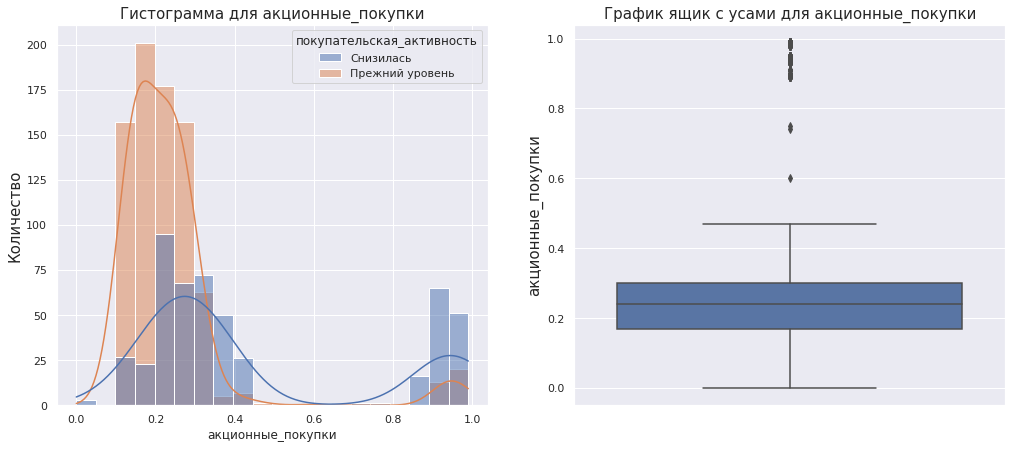

In [47]:
hist_with_wiskers(market_file, 'акционные_покупки', 'покупательская_активность')

Очень выглядит так, что большинство покупателей не ориентируются на скидки. Но тем не менее есть существенная часть клиентов, которые отлеживают скидки. Поэтому подготовке данных для модели разумным будет разделить пользователей на две части часто покупает по акции и редко покупает по акции, превратив колонку Акционные_покупки в категоральный признак.

Название столбца: популярная_категория


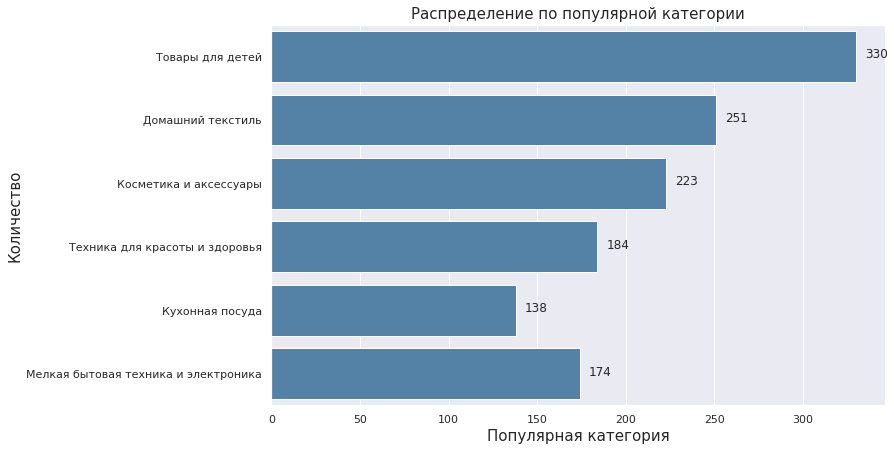

Значения датафрейма:
                                      Количество      Доля
популярная_категория                                      
Кухонная посуда                              138  0.106154
Мелкая бытовая техника и электроника         174  0.133846
Техника для красоты и здоровья               184  0.141538
Косметика и аксессуары                       223  0.171538
Домашний текстиль                            251  0.193077
Товары для детей                             330  0.253846

Описание датафрейма:
count      6.000000
mean     216.666667
std       68.028425
min      138.000000
25%      176.500000
50%      203.500000
75%      244.000000
max      330.000000
Name: Количество, dtype: float64


In [48]:
quality_go(
    market_file, 
    'популярная_категория',
    'Популярная категория',
    'Количество', 
    'Распределение по популярной категории'
)

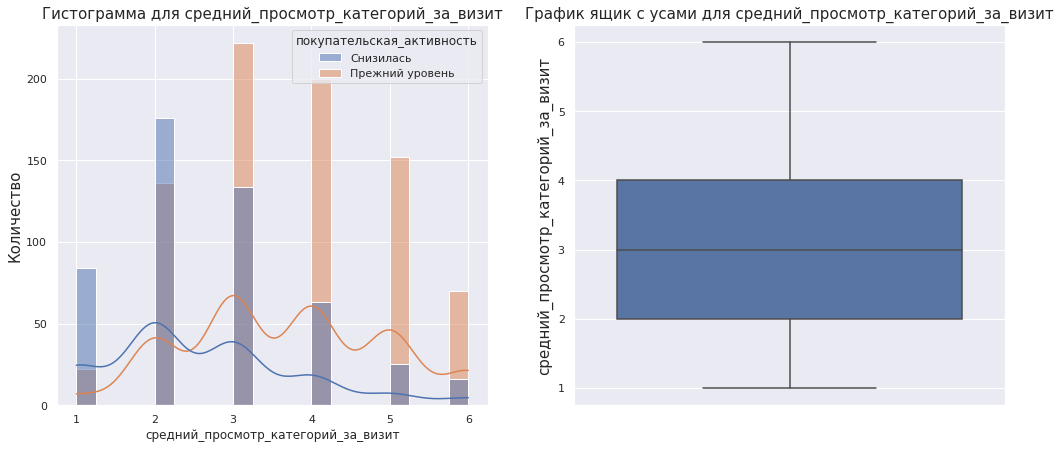

In [49]:
hist_with_wiskers(market_file, 'средний_просмотр_категорий_за_визит', 'покупательская_активность')

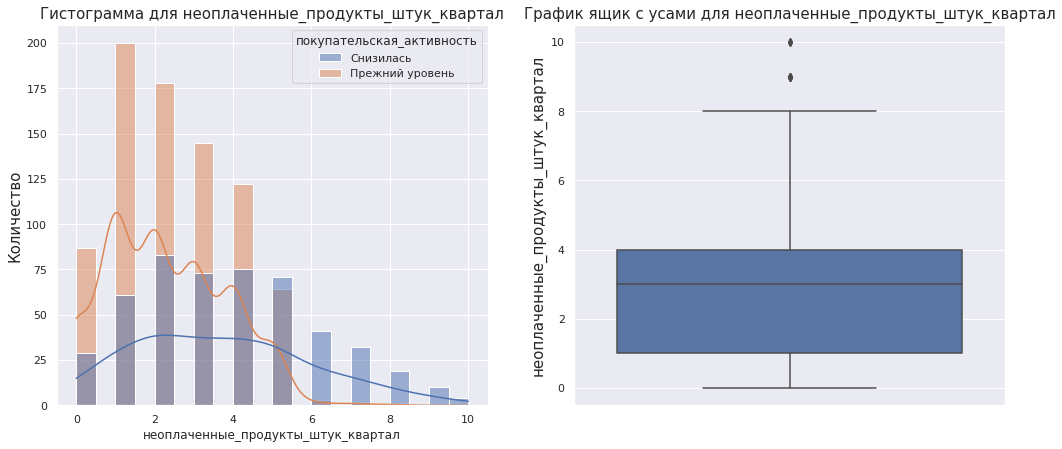

In [50]:
hist_with_wiskers(market_file, 'неоплаченные_продукты_штук_квартал', 'покупательская_активность')

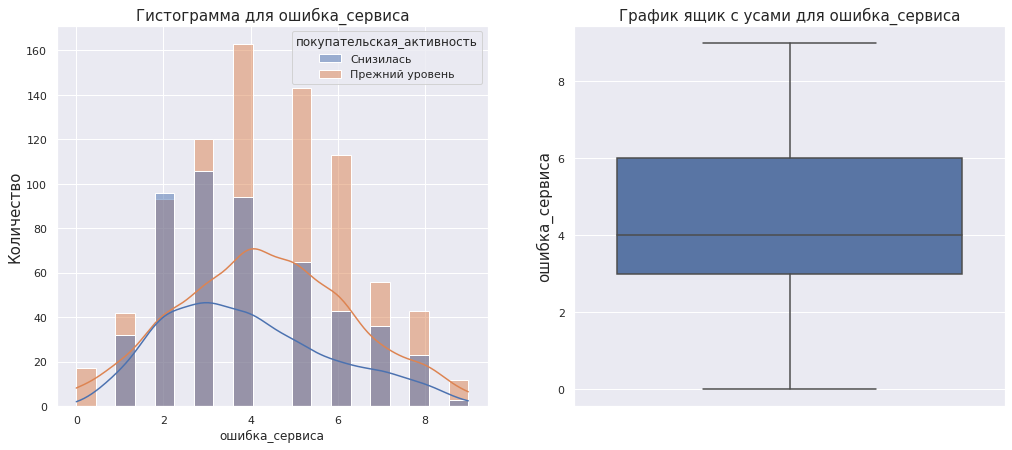

In [51]:
hist_with_wiskers(market_file, 'ошибка_сервиса', 'покупательская_активность')

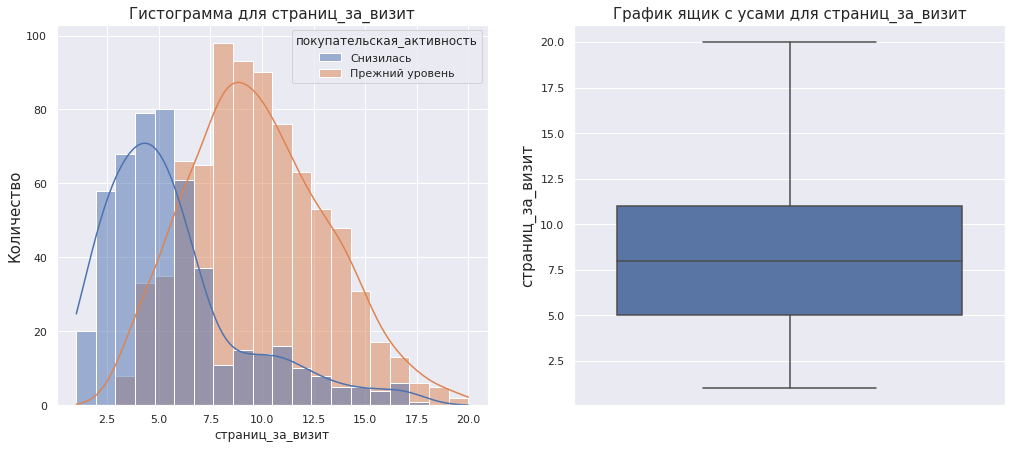

In [52]:
hist_with_wiskers(market_file, 'страниц_за_визит', 'покупательская_активность')

Название столбца: период


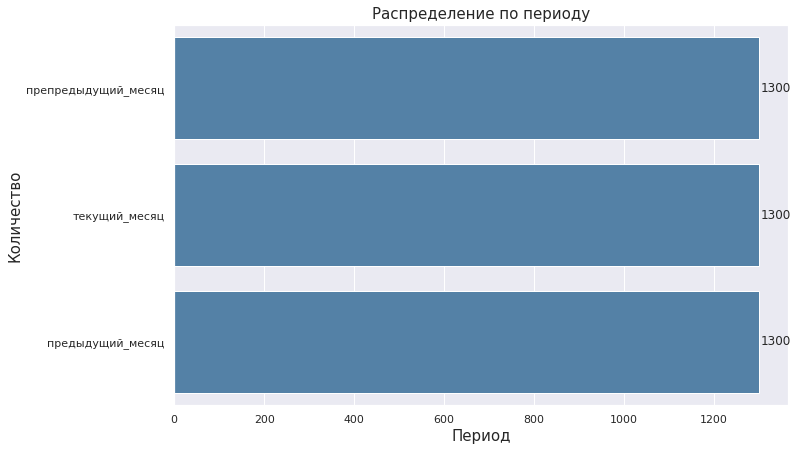

Значения датафрейма:
                     Количество      Доля
период                                   
предыдущий_месяц           1300  0.333333
препредыдущий_месяц        1300  0.333333
текущий_месяц              1300  0.333333

Описание датафрейма:
count       3.0
mean     1300.0
std         0.0
min      1300.0
25%      1300.0
50%      1300.0
75%      1300.0
max      1300.0
Name: Количество, dtype: float64


In [53]:
quality_go(
    market_money, 
    'период',
    'Период',
    'Количество', 
    'Распределение по периоду'
)

In [54]:
market_money_by_period = market_money.pivot_table(index='период', values=['выручка'], aggfunc='sum')
market_money_by_period

,выручка
период,
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0
текущий_месяц,6909449.1


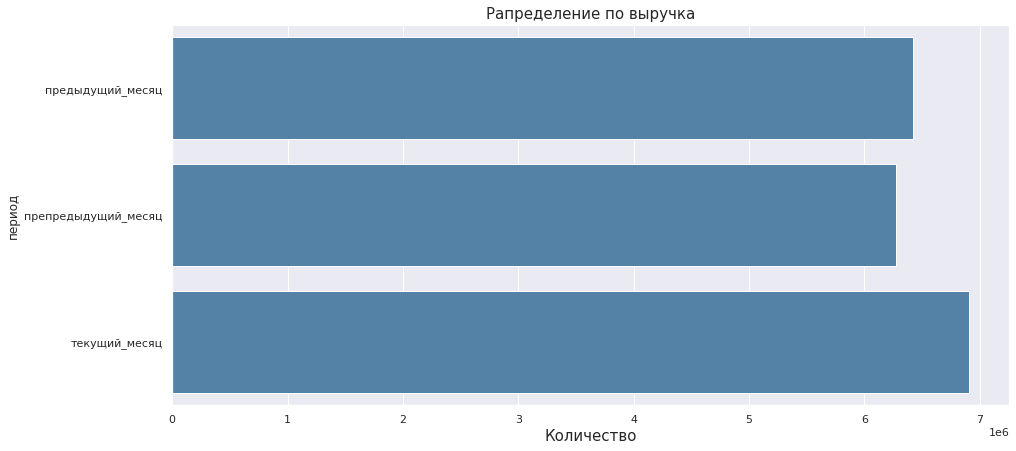

Описание датафрейма:
count          3.0
mean     6533405.0
std       333661.0
min      6272769.0
25%      6345383.0
50%      6417996.0
75%      6663723.0
max      6909449.0
Name: выручка, dtype: float64


In [55]:
pivot_bar_plot(market_money_by_period, 'выручка') 

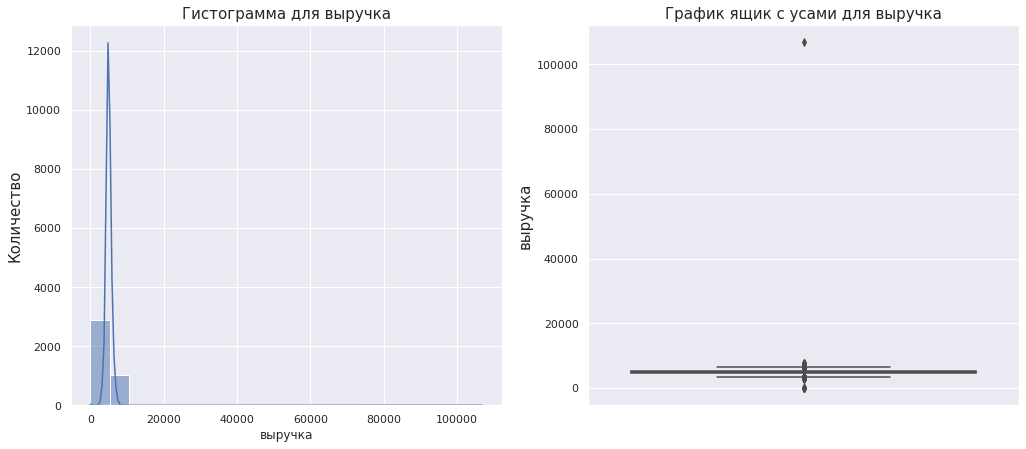

In [56]:
hist_with_wiskers(market_money, 'выручка', None)

In [57]:
market_money.query('выручка > 100000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


Похоже на выброс

In [58]:
market_money = market_money[market_money['выручка'] < 100000]

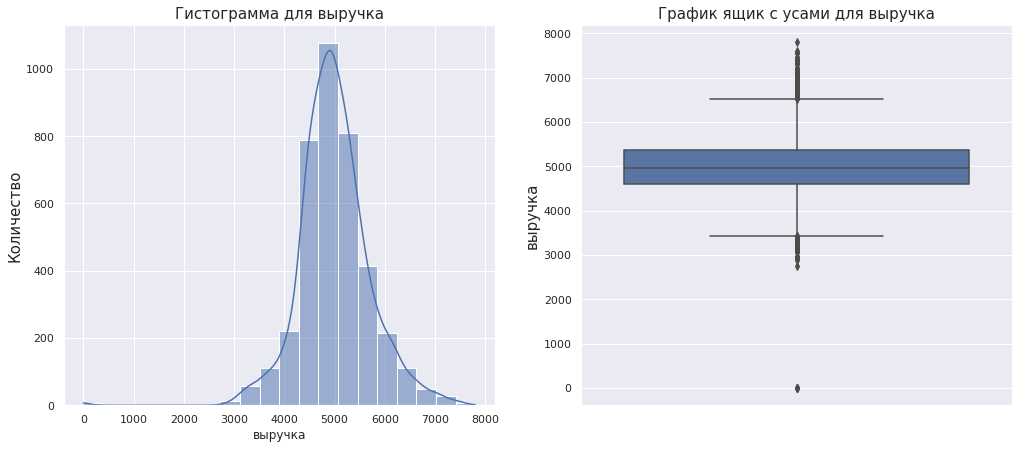

In [59]:
hist_with_wiskers(market_money, 'выручка', None)

In [60]:
market_money.query('выручка < 1')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


В дальнейшем мы хотим использовать только тех пользователей, у которых есть активность за три месяца

In [61]:
market_money = market_money[market_money['выручка'] > 0]

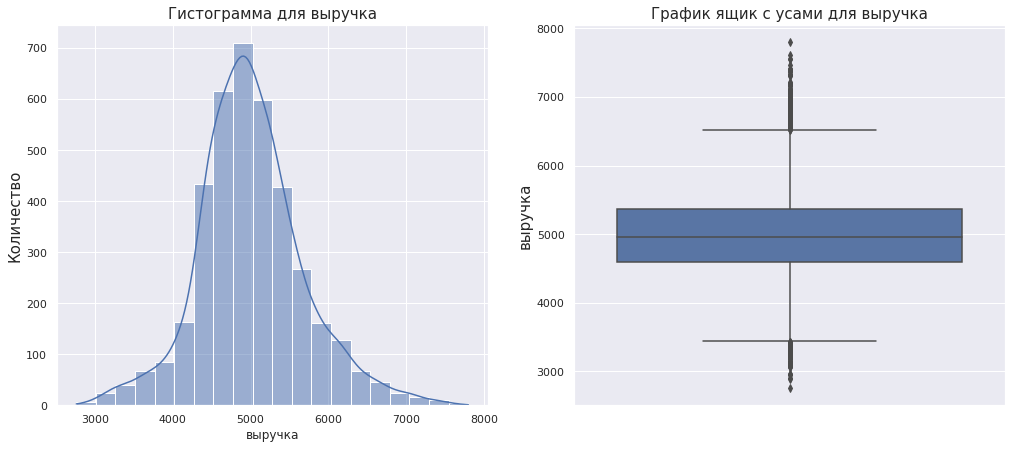

In [62]:
hist_with_wiskers(market_money, 'выручка', None)

In [63]:
market_time_by_period = market_time.pivot_table(index='период', values=['минут'], aggfunc='sum')
market_time_by_period

,минут
период,
предыдущий_месяц,17508
текущий_месяц,17166


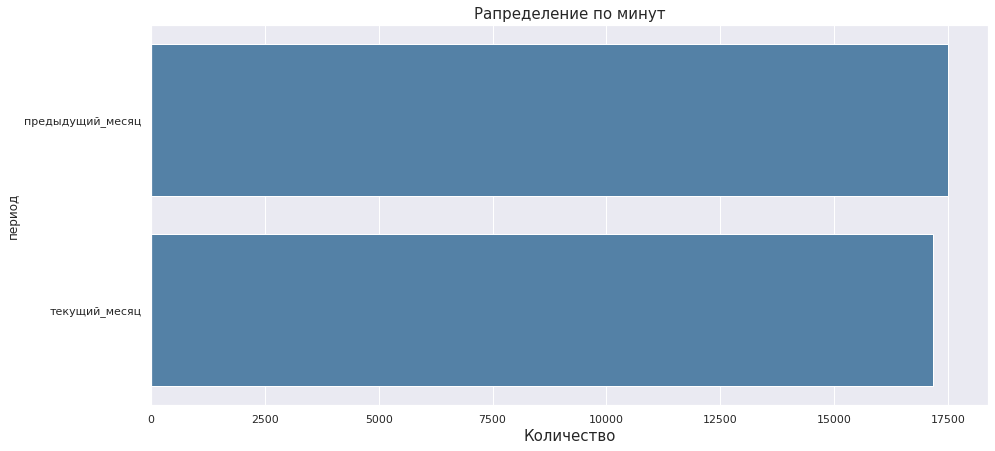

Описание датафрейма:
count        2.0
mean     17337.0
std        242.0
min      17166.0
25%      17252.0
50%      17337.0
75%      17422.0
max      17508.0
Name: минут, dtype: float64


In [64]:
pivot_bar_plot(market_time_by_period, 'минут') 

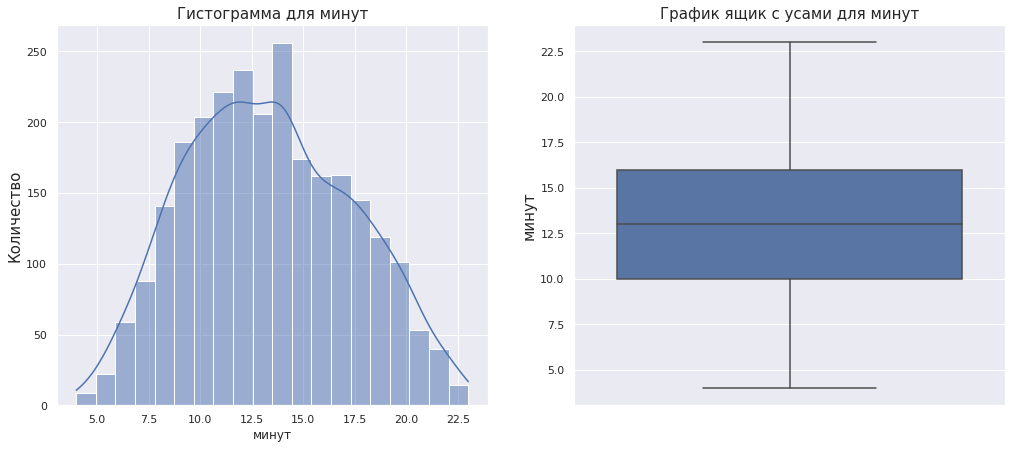

In [65]:
hist_with_wiskers(market_time, 'минут', None)

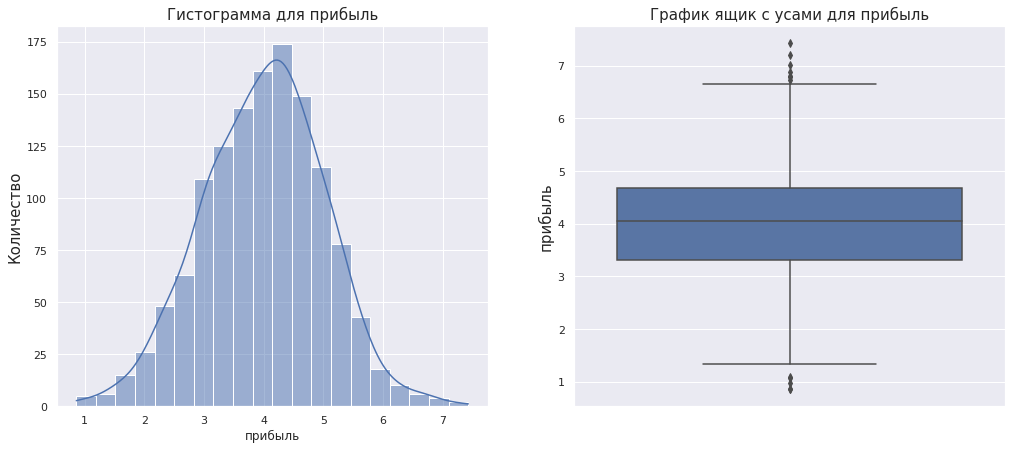

In [66]:
hist_with_wiskers(money, 'прибыль', None)

После того как мы исследовали данные, нужно отобрать клиентов с активностью не менее трех месяцев. 

Это значит, что нам нужны записи из **market_money**, где у клиента есть покупки за все три периода **'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'.**


In [67]:
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market_file = market_file[market_file['id'].isin(grouped.index)]
len(market_file)

1296

**Вывод:**

Был проведен исследовательский анализ данных. Было выявлено небольшое количество явно аномальных значений, которые были исключены из анализа. В целом данные выглядят неплохо. Так же оставили пользователей, которые совершали покупки в течение последних трех месяцев.

## Шаг. Объединение таблиц

### Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

### Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода

In [68]:
market_money_grouped = market_money.pivot_table(index=['id'], columns=["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

In [69]:
market_time_grouped = market_time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

In [70]:
market_full = market_file.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)

In [71]:
market_full.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


**Вывод:**
    
Теперь после объеденения датасетов все характеристики в одной таблице.

## Шаг. Корреляционный анализ

### Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


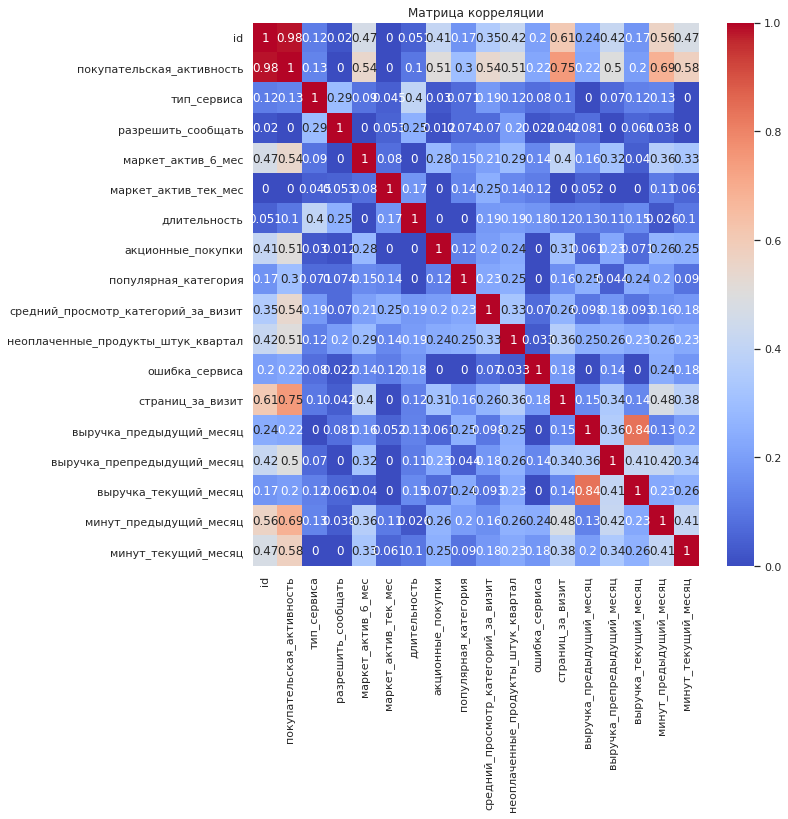

In [72]:
corr_matrix = market_full.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

In [73]:
def build_phik_corr_matrix(data, column):
    ax_col = 0
    ax_row = 0
    
    fig, axs = plt.subplots(ncols=1, nrows=data[column].nunique(), figsize=(20,20))
    for i in data[column].unique():
        data_i = data[data[column] == i]
        sns.heatmap(data_i.phik_matrix(), annot=True, cmap='cividis', ax=axs[ax_col])
        axs[ax_col].set_title(i)
        ax_col+=1
        if ax_col > 1:
            ax_col=0
            ax_row+=1  
    fig.tight_layout()
    plt.show()

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


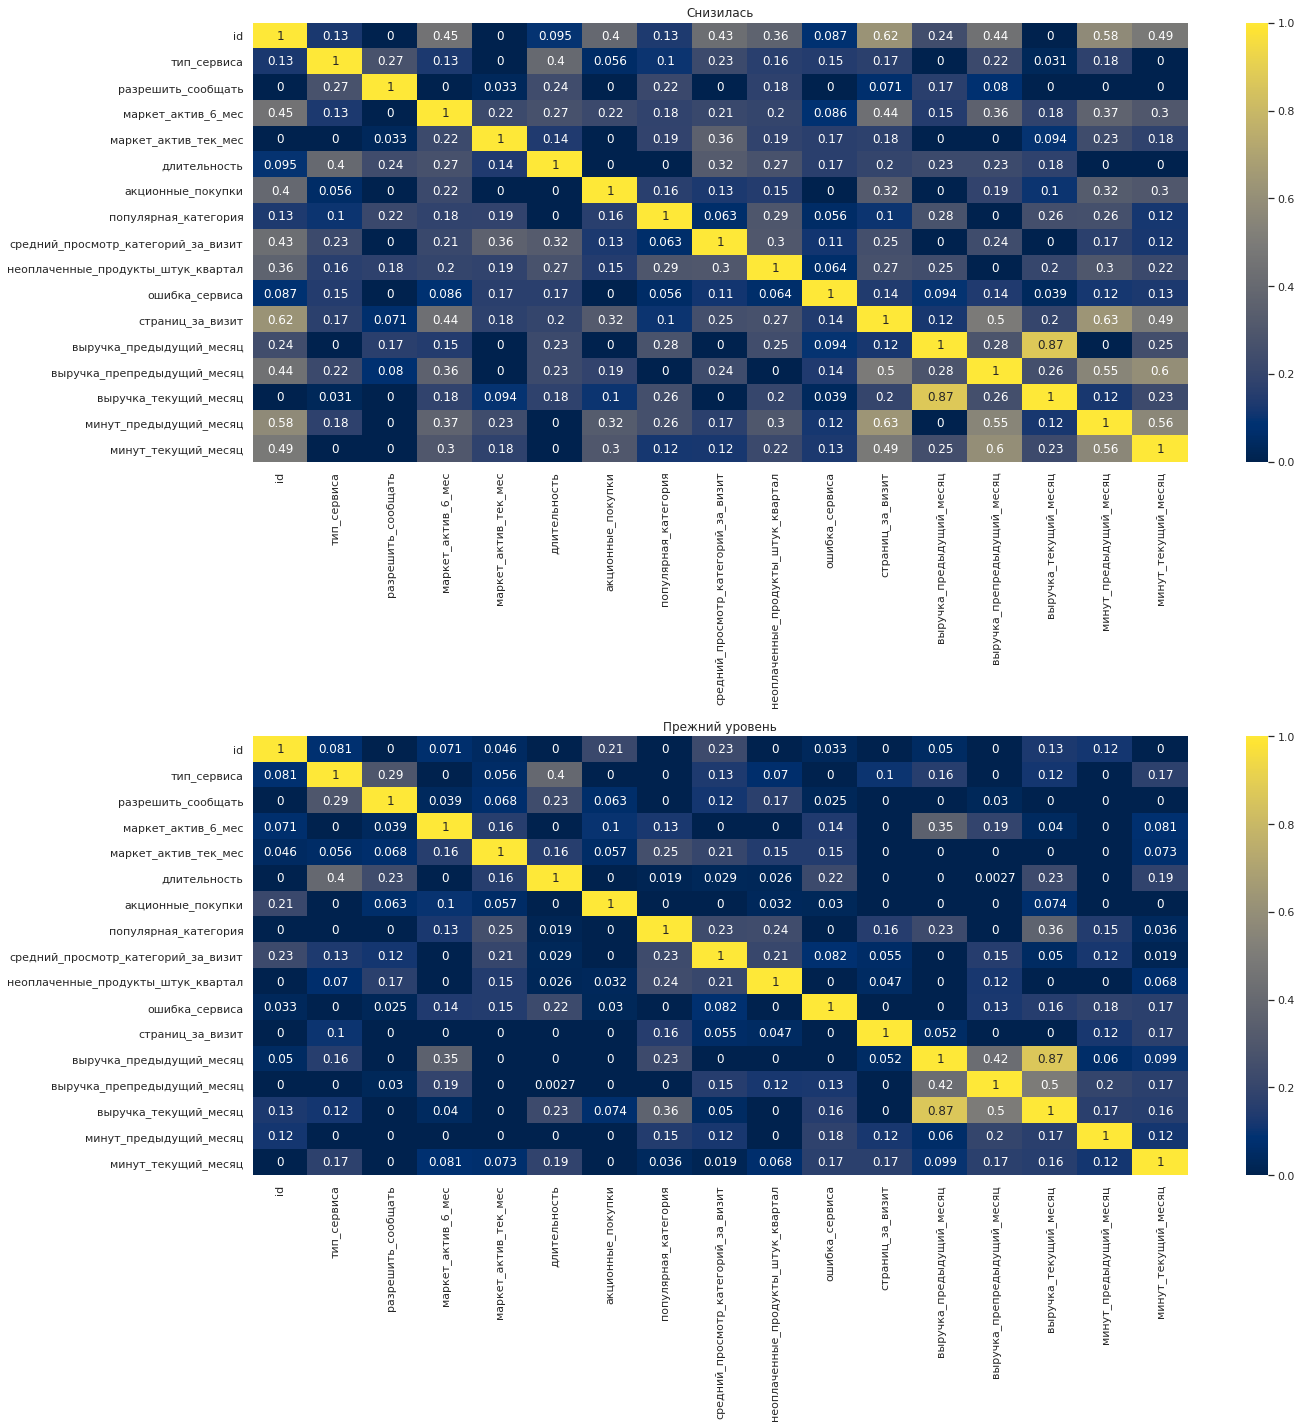

In [74]:
build_phik_corr_matrix(market_full, 'покупательская_активность')

**Вывод:**

Целевым признаком является **Покупательская_активность** и вот список полей, которые имеют корреляцию с ним: 
-	маркет_актив_6_мес
-	акционные_покупки
-	средний_просмотр_категорий_за_визит
-	неоплаченные_продукты_штук_квартал 
-	страниц_за_визит
-	выручка_препредыдущий_месяц
-	минут_предыдущий_месяц
-	минут_текущий_месяц


Среди признаков замечена только одна более-менее сильная корреляция **Выручка_предыдущий_месяц, Выручка_текущий_месяц.**
Но значение корреляции меньше 0.9 поэтому не будем удалять признаки.

Так же график показывает странную корреляцию Покупательская_активность и id, так что id так же уберем из датасета и так как он нам еще понадобиться то превратим его в индекс датасета.


## Шаг. Использование пайплайнов

Примените все изученные модели. Для этого используйте пайплайны.

### Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.



Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

Приступим к непосредственному построению модели. 

Мы переберем модели **KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC() используя пайплайны.**

Подготовим данные и закодируем целевой признак в значение 0 и 1, а также превратим колонку Акционные_покупки в категориальный признак.


In [75]:
market_full['покупательская_активность'] = market_full['покупательская_активность']\
.apply(lambda x: 1 if x == 'Снизилась' else 0)
market_full['покупательская_активность'] = market_full['покупательская_активность'].astype(int)  

In [76]:
market_full['акционные_покупки_категория'] = market_full['акционные_покупки']\
.apply(lambda x: 'Часто покупает по акции' if x >= 0.5 else 'Редко покупает по акции')
market_full = market_full.drop(['акционные_покупки'], axis=1)

In [77]:
market_full = market_full.set_index('id')

In [78]:
market_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,Часто покупает по акции
215350,1,стандарт,нет,4.9,3,539,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,Редко покупает по акции
215351,1,стандарт,да,3.2,5,896,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,Часто покупает по акции
215352,1,стандарт,нет,5.1,3,1064,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,Часто покупает по акции
215353,1,стандарт,да,3.3,4,762,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,Редко покупает по акции


### Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

In [79]:
X = market_full.drop(['покупательская_активность'], axis=1)
y = market_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [80]:
X_train.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,Редко покупает по акции


In [81]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория', 'тип_сервиса']

In [82]:
ord_columns = ['акционные_покупки_категория']

In [83]:
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'маркет_актив_тек_мес', 
               'длительность', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
               'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц']

In [84]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='error', sparse=False))
    ]
)

In [85]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['Редко покупает по акции','Часто покупает по акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [86]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [87]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [88]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [89]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [90]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория',
                                                                                'тип_сервиса']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simple_imputer_ord_...
                                        {'models': [LogisticRegression(C=1,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

### Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:

- использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
- использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [91]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория',
                                                   'тип_сервиса']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                                                                   SimpleImpute

In [92]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


In [93]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')

Метрика F1-score на тестовой выборке: 0.9


**Вывод:**

На данном шаге исследования была найдена и обучена модель для определения снижения активности покупателей сервиса. 

Лучшие результаты показала модель **LogisticRegression (C=2, penalty='l1', random_state=42, solver='liblinear').**

Метрика **roc_auc** для тестовой выборки показала результат **0.90,** для тестовой выборки **0.92.** Показатели очень хорошие, наша модель хорошо справляется с предсказанием. Так же метрика f1 показала и вовсе фантастические **0.90.**

У нас имеется дисбаланс в классах и все же он не помешал на получить такие высокие метрики.


## Шаг. Анализ важности признаков

### Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

In [94]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

In [95]:
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

In [96]:
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

In [97]:
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

In [98]:
shap_values = explainer(X_test_2)

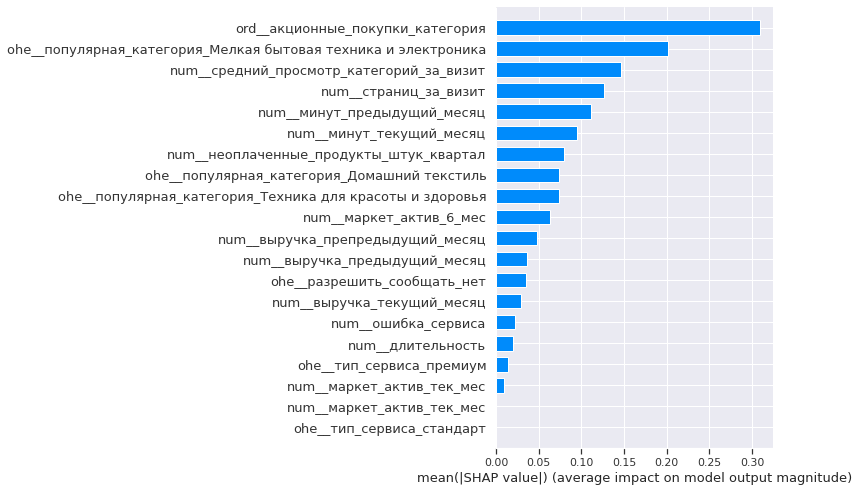

In [99]:
shap.summary_plot(shap_values, X_test_2, plot_type='bar', plot_size=(11,7))

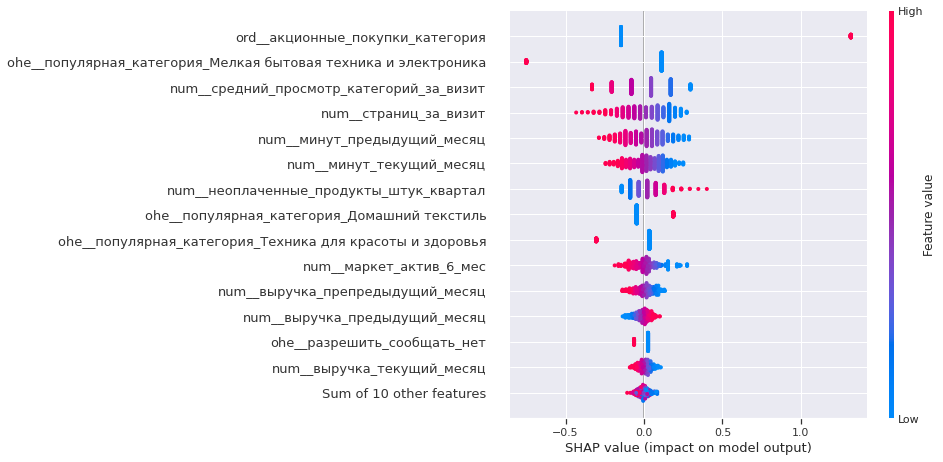

In [100]:
shap.plots.beeswarm(shap_values, max_display=15)

### Сделайте выводы о значимости признаков:
- какие признаки мало значимы для модели;
- какие признаки сильнее всего влияют на целевой признак;
- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

**Вывод:**

Получилось, что пять самых важных для модели признаков это: 
- страниц_за_визит, 
- средний_просмотр_категорий_за_визит, 
- мин_предыдущий_месяц, 
- мин_текущий_месяц, 
- неоплаченный_продукты_штук_квартал. 

Чем больше пролистаешь страниц те больше вероятность что найдешь нужный товар. Кроме того, при поиске той самой модели - продукта постоянно добавляешь в корзину интересные находки и в итоге покупаешь только что-то одно.

Малозначимыми признаками оказались:
- Популярная категория (кроме бытовой техники), 
- маркет_актив_тек_мес 
- мазрешить сообщать 
- тип_сервиса
- выручка_текущий_месяц
- длительность
- ошибка_сервиса 
- выручка_предыдущий_месяц 

И тут так же могу согласиться почти со всеми решениями модели. Мы рассматриваем только активных покупателей. Значит и дата регистрации, и падающие ошибки не так и важны. Сомнение у меня вызывает только Тип сервиса. Премиум пользователи, по идее должны постоянно покупать бытовые и расходные что бы в премиуме был смысл, но вот стандартные пользователи они менее постоянны. Странно что модель не посчитала это значимым признаком.
Если же попытаться дать рекомендацию о том, что делать что бы пользователь делал покупки чаще и приносил больше прибыли. То судя по всему нужно что бы он проводил на маркетплейсе больше времени. И как можно больше добавил продуктов в корзину. Не важно купит ли он один или несколько. Лишь бы у покупателя был выбор. 



## Шаг. Сегментация покупателей

### Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

In [101]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [102]:
X_test.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,Редко покупает по акции
215654,премиум,нет,1.4,4,684,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,Часто покупает по акции
216307,премиум,да,3.3,4,488,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,Редко покупает по акции
215501,премиум,да,3.5,3,1057,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,Редко покупает по акции
215934,стандарт,нет,5.5,4,147,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,Часто покупает по акции


In [103]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba

In [104]:
df_full = pd.concat([X_train_full, X_test_full])

In [105]:
money = money.set_index('id')
df_full = df_full.join(money)

In [106]:
df_full.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции,0.063495,4.37
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции,0.780894,4.03
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции,0.084639,4.37
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции,0.676107,5.58
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,Редко покупает по акции,0.752138,4.87


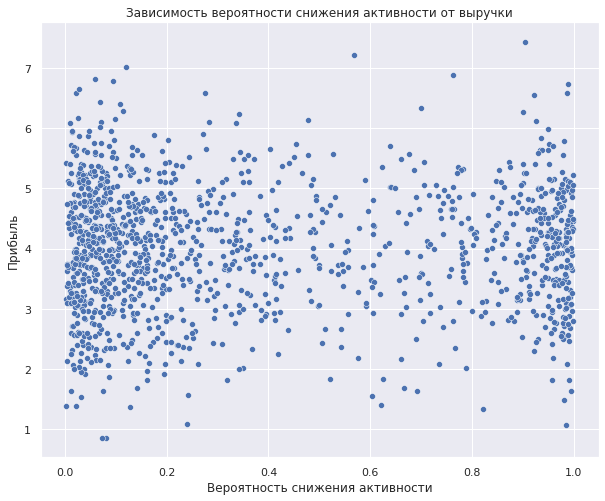

In [107]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

Получили диаграмму рассеяния Прибыли и Вероятности* снижения активности покупателя. 

Я не вижу зависимости вероятности снижения активности пользователя от прибыли.


In [108]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize=(10,8))
        sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.show()

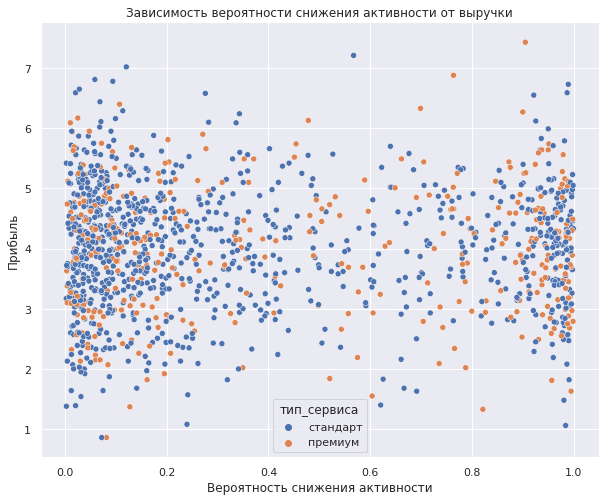

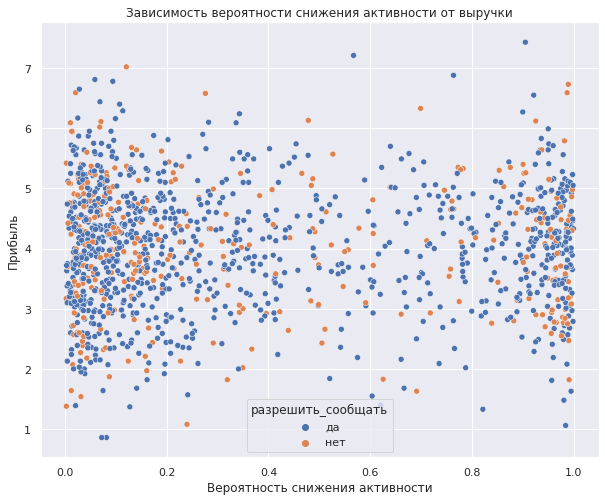

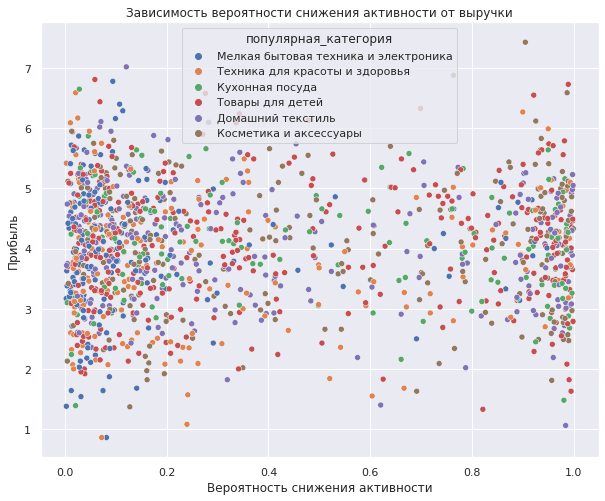

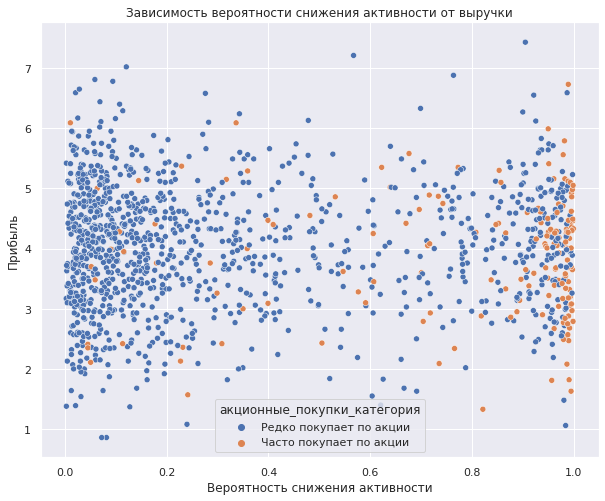

In [109]:
cat_columns = list(df_full.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

На графиках больше всего бросается в глаза распределение Акционные_покупки_категория. 

Пользователи, которые часто покупают по скидке чаще всего имеют высокую вероятность снижения активности. 
Это связанно, что скидки не постоянно и значит покупки пользователи совершают сезонно. И более того пользователи покупающие в основном по скидке представлены по всему распределению прибыли.

Попробуем проанализировать этот сегмент. Для этого добавим колонку и в ней промаркируем пользователей, которые часто покупают по акции и имеют вероятность снижения активности более 80%.


### Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
- Проведите графическое и аналитическое исследование группы покупателей.
- Сделайте предложения по работе с сегментом для увеличения покупательской активности.

In [110]:
df_full.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции,0.063495,4.37
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции,0.780894,4.03
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции,0.084639,4.37
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции,0.676107,5.58
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,Редко покупает по акции,0.752138,4.87


In [111]:
df_full['сегмент'] = df_full\
.apply( lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акционные_покупки_категория']=='Часто покупает по акции' \
        else 'Остальные пользователи', axis=1)

Название столбца: популярная_категория


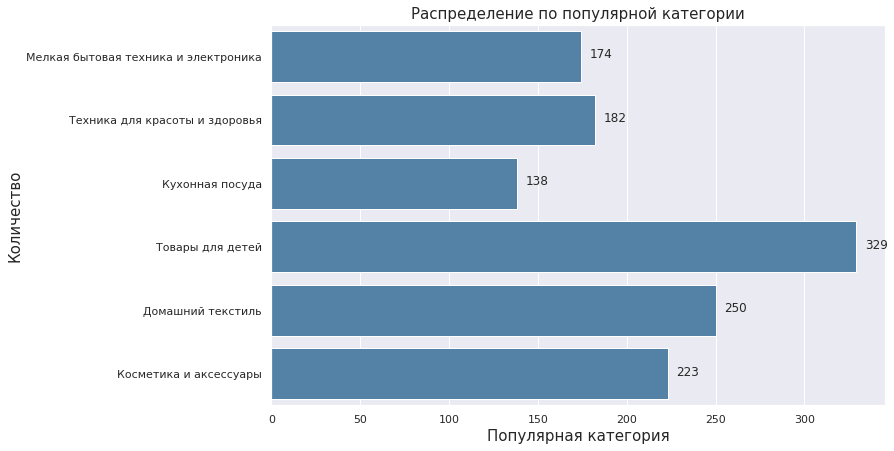

Значения датафрейма:
                                      Количество      Доля
популярная_категория                                      
Кухонная посуда                              138  0.106481
Мелкая бытовая техника и электроника         174  0.134259
Техника для красоты и здоровья               182  0.140432
Косметика и аксессуары                       223  0.172068
Домашний текстиль                            250  0.192901
Товары для детей                             329  0.253858

Описание датафрейма:
count      6.000000
mean     216.000000
std       67.790855
min      138.000000
25%      176.000000
50%      202.500000
75%      243.250000
max      329.000000
Name: Количество, dtype: float64


In [112]:
quality_go(
    df_full, 
    'популярная_категория',
    'Популярная категория',
    'Количество', 
    'Распределение по популярной категории'
)

Большие траты на детей.

Название столбца: тип_сервиса


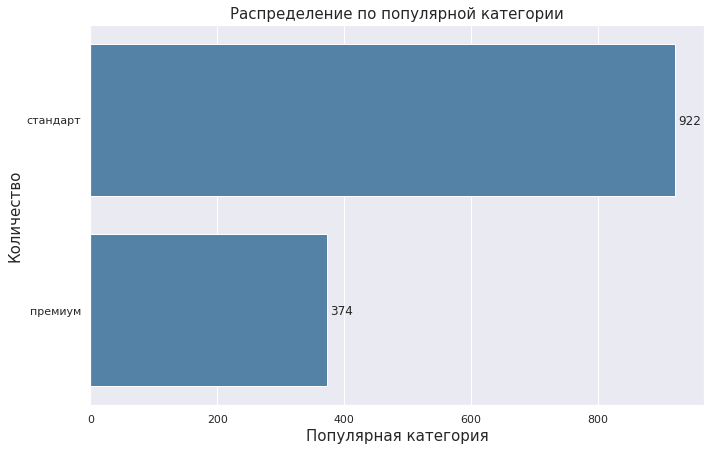

Значения датафрейма:
             Количество     Доля
тип_сервиса                     
премиум             374  0.28858
стандарт            922  0.71142

Описание датафрейма:
count      2.000000
mean     648.000000
std      387.494516
min      374.000000
25%      511.000000
50%      648.000000
75%      785.000000
max      922.000000
Name: Количество, dtype: float64


In [113]:
quality_go(
    df_full, 
    'тип_сервиса',
    'Популярная категория',
    'Количество', 
    'Распределение по популярной категории'
)

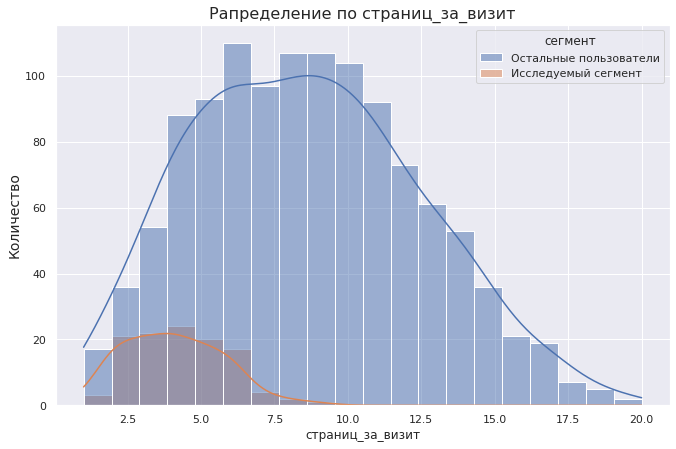

In [114]:
histogram(df_full, 'страниц_за_визит', 'сегмент')

Видно по пользователям по скидке просматривают меньше страниц. 

Похоже на то что эти пользователи не ищут и выбирают, а покупают целенаправленно.


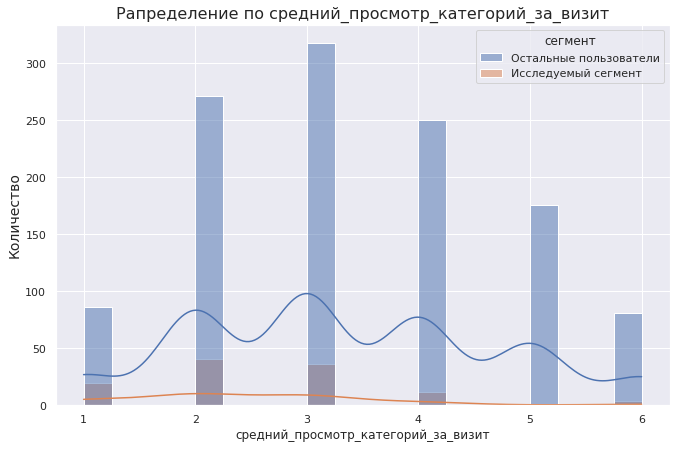

In [115]:
histogram(df_full, 'средний_просмотр_категорий_за_визит', 'сегмент')

Среднее количество просматриваемых категорий не различается.

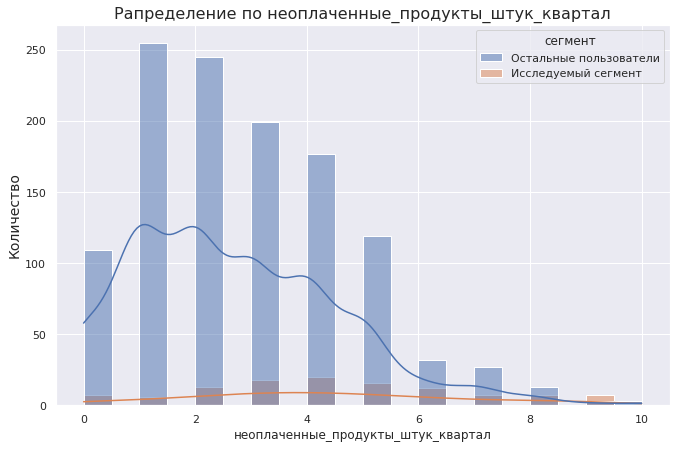

In [116]:
histogram(df_full, 'неоплаченные_продукты_штук_квартал', 'сегмент')

Пользователи из исследуемого сегмента в среднем оставляют неоплаченными в корзине больше товаров. 

Теперь сравним количество маркетинговых коммуникаций у покупателей по акции и всего массива пользователей.


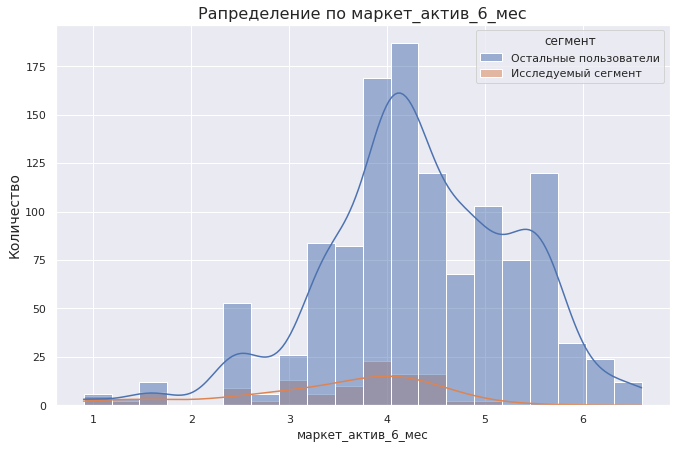

In [117]:
histogram(df_full, 'маркет_актив_6_мес', 'сегмент')

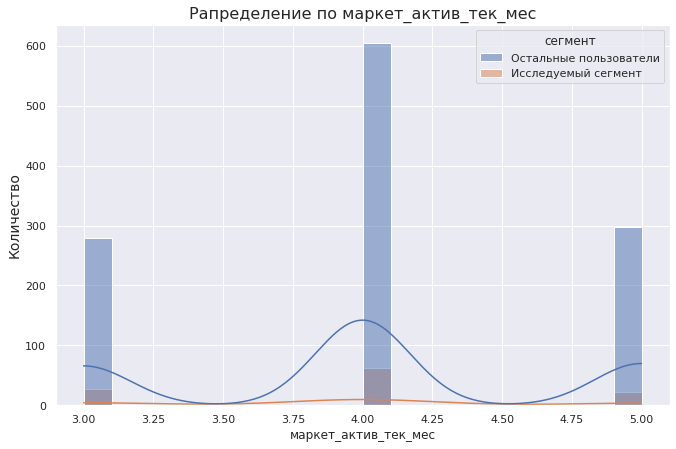

In [118]:
histogram(df_full, 'маркет_актив_тек_мес', 'сегмент')

### Сделайте выводы о сегментах:
- какой сегмент вы взяли для дополнительного исследования,
- какие предложения вы сделали и почему.

**Вывод:**

Покупатели по акции получали такое же количество внимания от маркетплейса как и все остальные пользователи. Это значит, что магазин не предоставляет им каких-либо дополнительных источников получения информации о скидках. Все либо содержится в письмах, что получают все пользователи, либо на главной странице сайта.
Мы рассмотрели некоторые признаки сегмента пользователей, которые покупают по скидке и имеют высокую вероятность снижения покупательской активности.

Попробуем описать его. Это пользователи, которые проводят не так много времени на сайте. Они не сравнивают товары, не выбирают лучший, они просматривают один-два товара и покупают.

Что же тогда можно предпринять что бы этот сегмент покупал больше, а значит приносил больше прибыли? 

Мои предложения:
- Не тратить средства на рассылки. Я не думаю, что человек, которые не хочет просматривать страницы с товарами будет просматривать рекламные материалы.
- Нужно сосредоточиться на главной странице сайте третировать ее под конкретного покупателя. Нужно что бы скидка как можно чаще обновлялись на главной странице. Что бы у человека была всего одна страница, которую он может быстро пролистать и не ходить по страницам.



## Шаг. Общий вывод

Сделайте общий вывод:

- опишите задачу;
- опишите исходные данные и проведённую предобработку;
- напишите, что вы сделали для поиска лучшей модели;
- укажите лучшую модель;
- добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

Задачей данного проекта была построение модели, которая бы предсказала уменьшение покупательской активности пользователей интернет-магазина "В один клик".

Другая задача стояла это исследование выбранного сегмента пользователей.

В рамках исследования были проделаны следующие шаги.

**Загрузка данных**

Исходными данными для исследования были четыре отдельных csv файла:
- с данными о поведении покупателя на сайте, коммуникации с ним и его продуктовом поведении.
- с данными о выручке, которую получает магазин с покупателя за период
- с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
- данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю Данные были загружены в датафреймы библиотеки pandas.

**Предобработка данных**

Исходные данные оказались хорошего качества, но тем не менее они требовали проведения некоторых работ перед началом анализа:
- стандартизация имен признаков. Наименования были оставлены на кириллице, но пробелы были заменены на землю.
- приведение типов данных. Некоторые числовые значения были считаны как строковые.
- обработка дублей. Если не учитывать колонку с уникальным идентификатором, то в датасете **market_file** было найдено 11 дублей. Дубли было решено оставить.
- обработка пропусков. Пропусков в данных не было найдено.

**Исследовательский анализ данных**

   На этом этапе были построены диаграммы распределения всех признаков. Отметим, что график распределения признака **Акционные_покупки** явно выделял две группы пользователей поэтому признак был превращен в категориальный.
    
**Корреляционный анализ данных**

   Целевым признаком является **Покупательская_активность** и вот список полей, которые имеют хоть корреляцию с ним: маркет_актив_6_мес, акционные_покупки, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, страниц_за_визит, выручка_препредыдущий_месяц, минут_предыдущий_месяц, минут_текущий_месяц.

   Так же график показал сильную зависимость между целевым признаком и id так что в дальнейшем при подготовке данных к обучению модели признак идентификатор был удален. Сильной корреляции между другими признаками не было выявлено поэтому все остальные признаки были оставлены в датасете.

**Объединение таблиц**

   Датасеты **market_file, market_money, market_time** были объединены в один датафрейм.

**Обучение модели**

   С использованием пайпланов из библиотеки **sklearn** были обучены модели **KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().** При обучении моделей средствами пайплана перебирались некоторое количество гиперпараметров моделей с целью нахождения модели, которая даст лучший результат.
    
   По результатам обучения лучшей стала модель **LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear').** Метрика **roc_auc для тренировочной выборки 0.90** для **тестовой 0.92.** Удивительно, но значения метрики имеют такой низкий разброс. И даже наличие дисбаланса в целевом признаке не помешало получить значение метрики **f1=0.90.**

**Анализ важности признаков**

   Если коротко, то самыми важными оказались признаки, связанные с количеством времени, которое покупатель проводит на маркетплейсе. А наименее важными, категории товаров, которые интересовали пользователи и коммуникации с пользователем.
    
   Кажется что все эти маркетинговые привлечения и спам на почту не помогают маркетплейсу. Важно лишь заставить пользователя проводить на сайте как можно больше времени и продажи вырастут.

**Сегментация пользователей**

   Для анализа пользователей был выбран сегмент пользователей часто покупающих по скидке и в то же время имеющих высокую вероятность снижения покупательской активности. Мое предложение по увеличение активности этого сегмента покупателей это таргетированная настройка главной страницы маркетплейса. А также более частое обновление скидок на главной странице. Пользователь не хочет ходить по страницам, он хочет видеть все предложения в одном месте.

